# Nonstructural Seismic Fragility Tool 
Tool to estimate fragility paramater of nonstrcutural building components from experimental testing database. Fits fragilities using the maximum liklihood estimation, assuming a lognormal distribution. 

Prior to running script ensure that all required packages are installed by running the following commands on your command line
 - pip install numpy
 - pip install scipy
 - pip install pandas
 - pip install matplotlib
 - pip install ipywidgets

## Import packages

In [1]:
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

## Load testing database

In [2]:
df = pd.read_csv('db_experiment.csv')
print(df)

            id  reference_id        specimen reviewer nistir_id p58_fragility  \
0     exp1001a  LEE-2007-SEI  Specimen No.1      NIST     C1011    C1011.001d   
1     exp1002a  LEE-2007-SEI  Specimen No.1      NIST     C1011    C1011.001d   
2     exp1003a  LEE-2007-SEI  Specimen No.1      NIST     C1011    C1011.001d   
3     exp1004a  LEE-2007-SEI  Specimen No.1      NIST     C1011    C1011.001d   
4     exp1005a  LEE-2007-SEI   Specimen No.2     NIST     C1011    C1011.001d   
...        ...           ...             ...      ...       ...           ...   
1422       NaN  PAN-2013-FUL             NaN     NIST     B2030           NaN   
1423       NaN  PAN-2013-FUL             NaN     NIST     B2030           NaN   
1424       NaN  PAN-2013-FUL             NaN     NIST     B2030           NaN   
1425       NaN  PAN-2013-FUL             NaN     NIST     B2030           NaN   
1426       NaN  PAN-2013-FUL             NaN     NIST     B2030           NaN   

                     comp_t

## Characterize Data

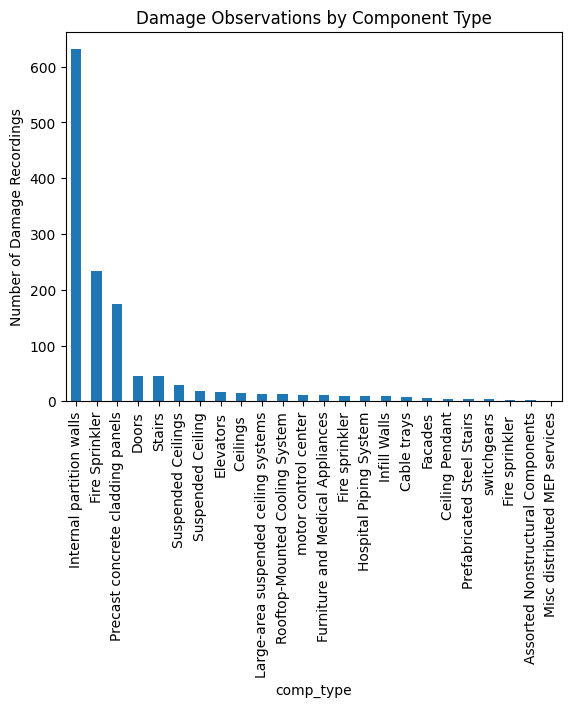

In [3]:
ax = df['comp_type'].value_counts(sort=True).plot.bar(rot=90, title='Damage Observations by Component Type')
ax.set_ylabel("Number of Damage Recordings");
comp_types = df['comp_type'].unique()
edp_types = df['ds_intensity_unit'].unique()

## Select Component Type and Fit Fragility
From the available component types listed above, select a type of component to develop a seismic fragility curve.

### Check if all damage records use the same demand parameter

In [4]:
def check_edp(comptype="Drywall Partitions"):
    newdf = df[(df['comp_type'] == comptype)]
    value_counts = newdf['ds_intensity_unit'].value_counts(sort=True)
    ax = value_counts.plot.bar(rot=90, title='Demand Parameters Observed')
    ax.set_ylabel("Number of Damage Recordings")
    
    edp_types_per_selected_comptype = value_counts.index.to_list()

In [5]:
widgets.interact(check_edp, comptype = comp_types);

interactive(children=(Dropdown(description='comptype', options=('Internal partition walls', 'Elevators', 'Stai…

### Plot Distribution of Damage Records

In [6]:
def check_intensity(comptype="Suspended Ceilings",edp='PFA (g), Horizontal in longitudinal direction'):
    newdf = df[(df['comp_type'] == comptype) & (df['ds_intensity_unit'] == edp)]
    convert_data = newdf[['ds_intensity']].apply(pd.to_numeric)
    ax = convert_data.plot.hist(column=["ds_intensity"], title='Component Capacity')
    ax.set_xlabel(edp);

def get_edp_types_per_selected_comptype(comptype="Suspended Ceilings"):
    newdf = df[(df['comp_type'] == comptype)]
    value_counts = newdf['ds_intensity_unit'].value_counts(sort=True)
    edp_types_per_selected_comptype = value_counts.index.to_list()
    return edp_types_per_selected_comptype


def update_edp_options(comptype):
    edp_types_per_selected_comptype = get_edp_types_per_selected_comptype(comptype)
    
    widgets.interact(check_intensity, comptype=widgets.fixed(comptype), edp=edp_types_per_selected_comptype)

In [9]:
widgets.interact(update_edp_options, comptype=comp_types);

interactive(children=(Dropdown(description='comptype', options=('Internal partition walls', 'Elevators', 'Stai…

### Fit Seismic Fragility

In [10]:
def fit_frag(comptype="Suspended Ceilings",edp='PFA (g), Horizontal in longitudinal direction'):
    newdf = df[(df['comp_type'] == comptype) & (df['ds_intensity_unit'] == edp)]
    if newdf.size > 0:
        convert_data = newdf[['ds_intensity']].apply(pd.to_numeric)

        # Rank the data
        ranked_data = convert_data.sort_values(by='ds_intensity')
        num_records = ranked_data.size
        ranked_data['rank'] = np.linspace(1, num_records, num=num_records)/num_records

        # Fit the fragility
        up_lim = ranked_data['ds_intensity'].max()
        x=np.linspace(0,up_lim,100)
        param = sp.stats.lognorm.fit(ranked_data['ds_intensity'])
        cdf_fitted = sp.stats.lognorm.cdf(x, param[0], loc=param[1], scale=param[2]) # fitted distribution

        # Plot the data
        ax = ranked_data.plot.scatter(x='ds_intensity', y='rank')
        plt.plot(x,cdf_fitted,'r-')
        ax.set_xlabel(edp);

        # Print the Fragility Parameters
        print('μ = ', round(param[2],3))
        print('β = ', round(param[0],2))
    else:
      print("No Damage Records")


def get_edp_types_per_selected_comptype(comptype="Suspended Ceilings"):
    newdf = df[(df['comp_type'] == comptype)]
    value_counts = newdf['ds_intensity_unit'].value_counts(sort=True)
    edp_types_per_selected_comptype = value_counts.index.to_list()
    return edp_types_per_selected_comptype

def update_edp_options(comptype):
    edp_types_per_selected_comptype = get_edp_types_per_selected_comptype(comptype)
    
    widgets.interact(fit_frag, comptype=widgets.fixed(comptype), edp=edp_types_per_selected_comptype)

In [11]:
widgets.interact(update_edp_options, comptype=comp_types);

interactive(children=(Dropdown(description='comptype', options=('Internal partition walls', 'Elevators', 'Stai…